### Packages

In [1]:
import polars as pl
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow
from datetime import datetime
import ast

### DuckDB connection

In [2]:
conn = duckdb.connect('/Users/yassinemernissi/Desktop/Backtothefuturekitchen/backtothefuturekitchen/10_preprod/data/mangetamain.duckdb')
df = pl.from_arrow(conn.execute("SELECT * FROM RAW_recipes").arrow())
conn.close()

In [3]:
df.head()

name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
str,i64,i64,i64,date,str,str,i64,str,str,str,i64
"""arriba baked winter squash m…",137739,55,47892,2005-09-16,"""['60-minutes-or-less', 'time-t…","""[51.5, 0.0, 13.0, 0.0, 2.0, 0.…",11,"""['make a choice and proceed wi…","""autumn is my favorite time of …","""['winter squash', 'mexican sea…",7
"""a bit different breakfast piz…",31490,30,26278,2002-06-17,"""['30-minutes-or-less', 'time-t…","""[173.4, 18.0, 0.0, 17.0, 22.0,…",9,"""['preheat oven to 425 degrees …","""this recipe calls for the crus…","""['prepared pizza crust', 'saus…",6
"""all in the kitchen chili""",112140,130,196586,2005-02-25,"""['time-to-make', 'course', 'pr…","""[269.8, 22.0, 32.0, 48.0, 39.0…",6,"""['brown ground beef in large p…","""this modified version of 'mom'…","""['ground beef', 'yellow onions…",13
"""alouette potatoes""",59389,45,68585,2003-04-14,"""['60-minutes-or-less', 'time-t…","""[368.1, 17.0, 10.0, 2.0, 14.0,…",11,"""['place potatoes in a large po…","""this is a super easy, great ta…","""['spreadable cheese with garli…",11
"""amish tomato ketchup for can…",44061,190,41706,2002-10-25,"""['weeknight', 'time-to-make', …","""[352.9, 1.0, 337.0, 23.0, 3.0,…",5,"""['mix all ingredients& boil fo…","""my dh's amish mother raised hi…","""['tomato juice', 'apple cider …",8


#### Minutes

## Pré-traitement data et data quality!

#### Submission date

In [ ]:
# Basic Data quality check
df.select([
    pl.col("submitted").is_null().sum().alias("n_missing"),
    (pl.col("submitted") < pl.date(1999,1,1)).sum().alias("before_1999"),
    (pl.col("submitted") > pl.date(2019,12,31)).sum().alias("after_2019")
])

n_missing,before_1999,after_2019
u32,u32,u32
0,0,0


In [ ]:
# Feature extraction
df = df.with_columns([
    pl.col("submitted").dt.year().alias("year"),
    pl.col("submitted").dt.month().alias("month"),

    # Weekend flag
    (pl.col("submitted").dt.weekday() >= 5).cast(pl.Int8).alias("is_weekend"),

    # Season flag
    (
        pl.when(pl.col("month").is_in([12, 1, 2])).then(pl.lit("Winter"))
        .when(pl.col("month").is_in([3, 4, 5])).then(pl.lit("Spring"))
        .when(pl.col("month").is_in([6, 7, 8])).then(pl.lit("Summer"))
        .otherwise(pl.lit("Autumn"))
        .alias("season")
    )
])

# Column replace
df = df[[
    "name", "description", "id", "minutes", "contributor_id", "submitted", "year", "month", "weekday", "is_weekend", "season",
    "tags", "nutrition", "n_steps", "steps",  "n_ingredients", "ingredients", 
]]

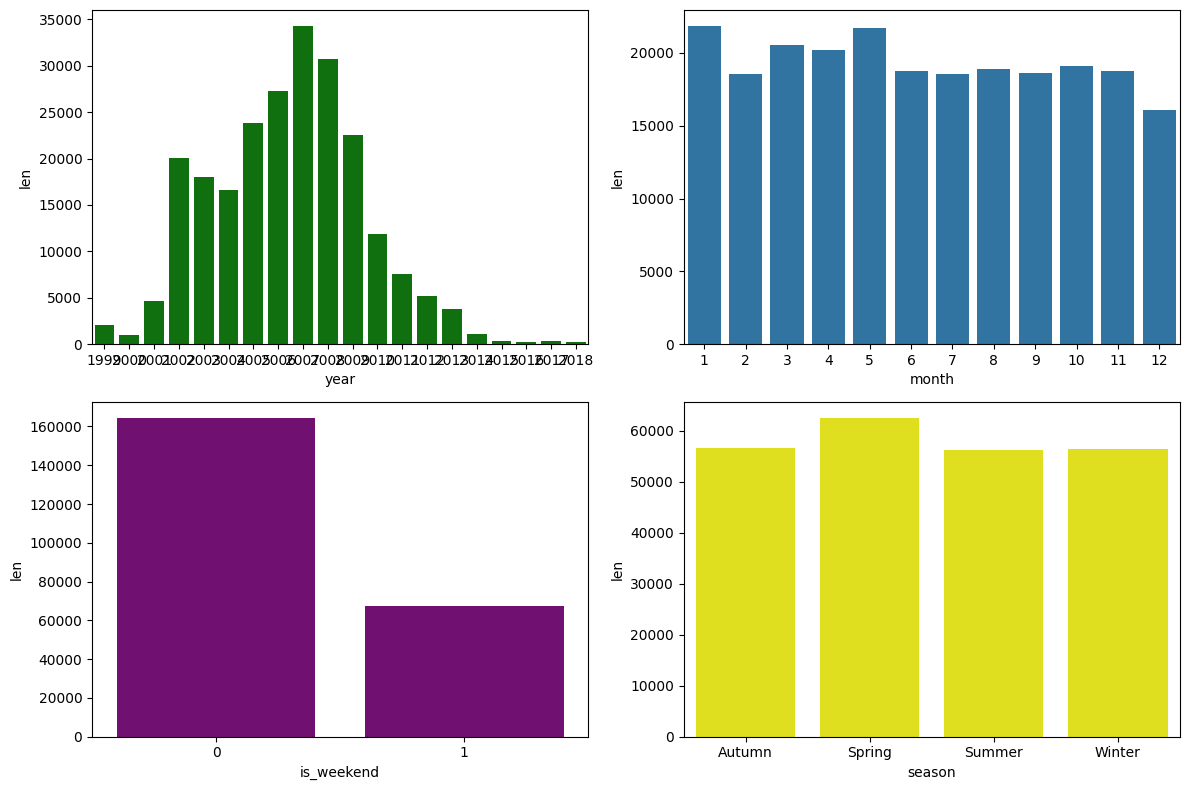

In [75]:
# Préparation des données regroupées
by_year = df.group_by("year").len().sort("year").to_pandas()
by_month = df.group_by("month").len().sort("month").to_pandas()
by_weekend = df.group_by("is_weekend").len().sort("is_weekend").to_pandas()
by_season = df.group_by("season").len().sort("season").to_pandas()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.barplot(data=by_year, x="year", y="len", color="green", ax=axes[0,0])
sns.barplot(data=by_month, x="month", y="len", ax=axes[0,1])
sns.barplot(data=by_weekend, x="is_weekend", y="len", color="purple", ax=axes[1,0])
sns.barplot(data=by_season, x="season", y="len", color="yellow", ax=axes[1,1])

plt.tight_layout()
plt.show()


#### Minutes

In [104]:
# Data quality summary
dq = df.select([
    pl.col("minutes").is_null().sum().alias("missing"),
    pl.col("minutes").min().alias("min"),
    pl.col("minutes").max().alias("max"),
    (pl.col("minutes") <= 0).sum().alias("recipes_at_0"),
    (pl.col("minutes") > 180).sum().alias("recipes_sup_24h"),
])

print("=== DATA QUALITY CHECK ON `minutes` ===")
print(dq)

# Log de suppression des lignes
before = df.height
df = df.filter((pl.col("minutes") > 0) & (pl.col("minutes") <= 180))
after = df.height

removed = before - after
pct_removed = (removed / before) * 100

print(f">>> Removed {removed}/{before} rows ({pct_removed:.2f}%) based on minutes filtering (<=0 or >3h)")

=== DATA QUALITY CHECK ON `minutes` ===
shape: (1, 5)
┌─────────┬─────┬────────────┬──────────────┬─────────────────┐
│ missing ┆ min ┆ max        ┆ recipes_at_0 ┆ recipes_sup_24h │
│ ---     ┆ --- ┆ ---        ┆ ---          ┆ ---             │
│ u32     ┆ i64 ┆ i64        ┆ u32          ┆ u32             │
╞═════════╪═════╪════════════╪══════════════╪═════════════════╡
│ 0       ┆ 0   ┆ 2147483647 ┆ 1094         ┆ 17388           │
└─────────┴─────┴────────────┴──────────────┴─────────────────┘
>>> Removed 18482/231637 rows (7.98%) based on minutes filtering (<=0 or >3h)


In [106]:
# Calculer les moyennes par groupe
avg_year = df.group_by("year").agg(pl.col("minutes").mean().alias("avg_minutes")).sort("year").to_pandas()
avg_month = df.group_by("month").agg(pl.col("minutes").mean().alias("avg_minutes")).sort("month").to_pandas()
avg_weekend = df.group_by("is_weekend").agg(pl.col("minutes").mean().alias("avg_minutes")).sort("is_weekend").to_pandas()
avg_season = df.group_by("season").agg(pl.col("minutes").mean().alias("avg_minutes")).sort("season").to_pandas()

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Moyenne par année
sns.barplot(data=avg_year, x="year", y="avg_minutes", color="skyblue", ax=axes[0,0])
axes[0,0].set_title("⏱️ Temps moyen par année")
axes[0,0].tick_params(axis='x', labelsize=8)
for i, v in enumerate(avg_year["avg_minutes"]):
    axes[0,0].text(i, v, f"{v:.1f}", ha='center', va='bottom', fontsize=8)

# 2. Moyenne par mois
sns.barplot(data=avg_month, x="month", y="avg_minutes", color="orange", ax=axes[0,1])
axes[0,1].set_title("⏱️ Temps moyen par mois")
axes[0,1].tick_params(axis='x', labelsize=8)
for i, v in enumerate(avg_month["avg_minutes"]):
    axes[0,1].text(i, v, f"{v:.1f}", ha='center', va='bottom', fontsize=8)

# 3. Moyenne Weekday vs Weekend
sns.barplot(data=avg_weekend, x="is_weekend", y="avg_minutes", color="green", ax=axes[1,0])
axes[1,0].set_title("⏱️ Temps moyen Weekday vs Weekend")
axes[1,0].set_xticklabels(["Weekday", "Weekend"])
axes[1,0].tick_params(axis='x', labelsize=8)
for i, v in enumerate(avg_weekend["avg_minutes"]):
    axes[1,0].text(i, v, f"{v:.1f}", ha='center', va='bottom', fontsize=8)

# 4. Moyenne par saison
sns.barplot(data=avg_season, x="season", y="avg_minutes", color="purple", ax=axes[1,1])
axes[1,1].set_title("⏱️ Temps moyen par saison")
axes[1,1].tick_params(axis='x', labelsize=8)
for i, v in enumerate(avg_season["avg_minutes"]):
    axes[1,1].text(i, v, f"{v:.1f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

ColumnNotFoundError: unable to find column "year"; valid columns: ["name", "id", "minutes", "contributor_id", "submitted", "tags", "nutrition", "n_steps", "steps", "description", "ingredients", "n_ingredients"]

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["name", "id", "minutes", "contributor_id", ...]; PROJECT */12 COLUMNS